In [1]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def check_tria_ineq(K_candidate):
    D = 0.5* (np.diag(K_candidate).reshape(-1,1) @ np.ones((K_candidate.shape[0], 1)).T + np.ones((K_candidate.shape[0], 1)) @ np.diag(K_candidate).reshape(1,-1)) - K_candidate
    # sns.heatmap(D)
    # plt.title(f'Distance')
    # plt.show()
    tria_ineq = True
    for x in range(len(D)):
        if not tria_ineq: break
        for y in range(x+1, len(D)):
            if not tria_ineq: break
            for z in range(y+1, len(D)):
                if not tria_ineq: break
                diff1 = D[x,y] + D[x,z] - D[y,z]
                diff2 = D[x,z] + D[y,z] - D[x,y]
                diff3 = D[y,z] + D[x,y] - D[x,z]
                if (diff1 < 0 ) or (diff2 < 0 ) or (diff3 < 0):
                    print(f'Invalid Triangle Inequality (Triplet: No.{x+1,y+1,z+1})')
                    print(f'D[{x},{y}] + D[{x},{z}] - D[{y},{z}] {diff1}')
                    print(f'D[{x},{z}] + D[{y},{z}] - D[{x},{y}] {diff2}')
                    print(f'D[{y},{z}] + D[{x},{y}] - D[{x},{z}] {diff3}')
                    tria_ineq = False

    return tria_ineq

def check_psd(K):
    eigenValues = np.linalg.eigvals(K) #scipy.linalg.eigh(K_new, eigvals_only=True) 
    psd = 'True'
    print("K's min eigenvalue:",min(eigenValues))
    if (0 - min(eigenValues)) > 1e-08: 
        psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
        plt.figure(figsize=(3,2))
        sns.heatmap(K)
        plt.title(f'psd: {psd}')
        plt.show()
        psd = 'True'
        K = K - float(min(eigenValues)) * np.eye(K.shape[0])
        eigenValues = np.linalg.eigvals(K) 
        print("K_new's min eigenvalue:",min(eigenValues))
        if (0 - min(eigenValues)) > 1e-08: 
            psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'    
    plt.figure(figsize=(3,2))
    sns.heatmap(K)
    plt.title(f'psd: {psd}')
    plt.show()

In [4]:
dataname = 'ENZYMES'

print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname.upper(), verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target

Fetching ENZYMES dataset...
Finish fetching!


In [5]:
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

In [6]:
[len(np.where(y_adj == num)[0]) for num in np.unique(y)], len(G_adj)

([100, 100, 100, 100, 100, 100], 600)

In [7]:
K_dict = dict()

# Get Kernels

## WL [WeisfeilerLehman]

In [8]:
def get_WL(G, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'WL-{iter_num}')
    plt.show()
    return K

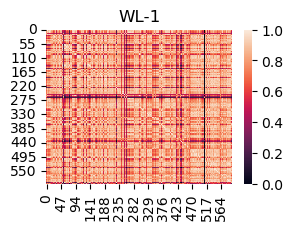

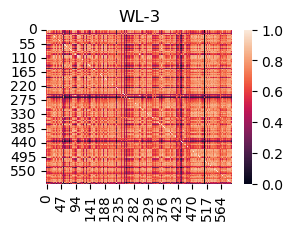

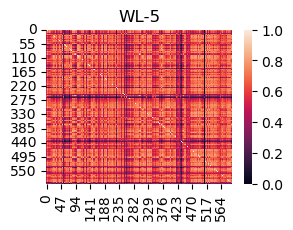

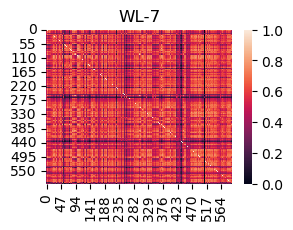

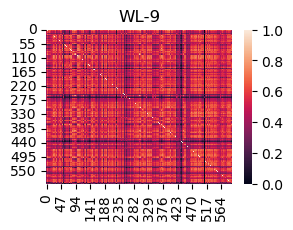

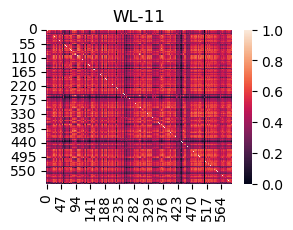

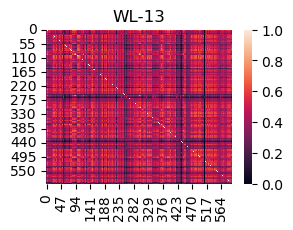

In [9]:
for h in range(1, 15, 2):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)

## GS [GraphletSampling]

In [10]:
def get_GS(G, k_num = 4):
    wl_kernel = GraphletSampling(normalize=True, k=k_num)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'GS-{k_num} train')
    plt.show()

    return K

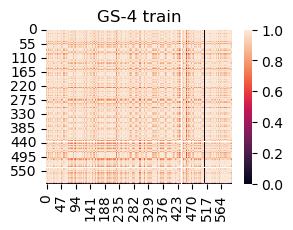

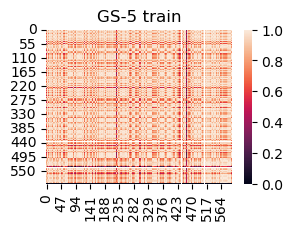

KeyboardInterrupt: 

In [11]:
for k in range(4, 10):
    name = f'K_GS_{k}'
    K_dict[name] = get_GS(G_adj, k)

## SP [ShortestPath]

In [12]:
def get_SP(G, algo):
    wl_kernel = ShortestPath(normalize=True, algorithm_type=algo)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'SP {algo}')
    plt.show()
    
    return K

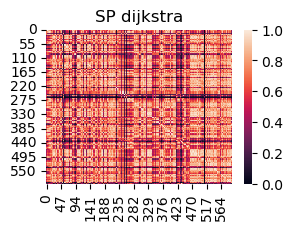

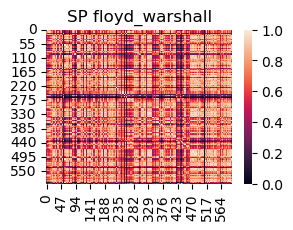

In [13]:
for algo in ["dijkstra", "floyd_warshall"]:
    name = f'K_SP_{algo}'
    K_dict[name] = get_SP(G_adj, algo)

## RW [RandomWalk]

In [13]:
def get_RW(G, lambda_value = 0.1):
    wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'RW-{lambda_value}')
    plt.show()

    return K

In [14]:
# for lam in range(5, 32, 5):
#     lam /= 10.
#     name = f'K_RW_{lam}'
#     K_dict[name] = get_RW(G_adj, lam)

In [15]:
import scipy
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import pandas as pd

In [27]:
def cal_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind_row, ind_col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind_row, ind_col)]) * 1.0 / y_pred.size


def cal_Lap_eigen(K, class_num):
    L = csgraph.laplacian(K, normed=True)
    eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[class_num-1, class_num])
    return (eigenValues, eigenVectors[0], eigenVectors[1])

def gk_L(K, coef = 1):

    n = K.shape[0]
    D = np.sum(K, axis = 0)

    D15 = np.diag(np.power(D, -1.5))
    D05 = np.diag(np.power(D, -0.5))
    D1 = np.diag(np.power(D, -1))

    U0 = - 0.5 * D15 @ K @ D05 * coef
    U1 = - 0.5 * D05 @ K @ D15 * coef

    U0 = np.tile(U0.sum(axis = 1), (n, 1))
    U1 = np.transpose(np.tile(U1.sum(axis = 0), (n, 1)))
    grad_K = - (U0 + U1 + D1 * coef)
    
    return grad_K

def gw_K(K_list):
    return np.array(K_list)

def get_Knew(prev_w, K_list):
    T = len(prev_w)
    p, q = K_list[0].shape

    K_new = np.zeros((p, q))
    for t in range(T):
        K_new += prev_w[t] * K_list[t]
    return K_new

def cal_grad_w(prev_w, K_list, K_new, class_num):

    T = len(prev_w)
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_new, class_num)
    eigen_k = eigenValues[0]
    eigen_gap = np.diff(eigenValues)
    eigen_gap_ratio = eigen_gap/eigen_k
    eigenV_kp1_trace = np.transpose(eigenV_kp1 @ eigenV_kp1)
    eigenV_trace = np.transpose(eigenV @ eigenV)
    inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
    inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)

    grad_LK = gk_L(K_new, (inv_trace1 - inv_trace2))
    grad_Lw = gw_K(K_list)
    grad = np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    return grad.flatten(), eigen_gap_ratio


In [17]:
def project_simplex(x):
    """ Take a vector x (with possible nonnegative entries and non-normalized)
        and project it onto the unit simplex.
    """
    xsorted = np.sort(x)[::-1]
    # remaining entries need to sum up to 1
    sum_ = 1.0

    lambda_a = (np.cumsum(xsorted) - sum_) / np.arange(1.0, len(xsorted)+1.0)
    for i in range(len(lambda_a)-1):
        if lambda_a[i] >= xsorted[i+1]:
            astar = i
            break
    else:
        astar = -1

    p = np.maximum(x-lambda_a[astar],  0)
    return p

In [18]:
len(K_dict.values())

11

In [19]:
def train(K_list, init_type, class_num = 2, stepsize = 1e-4, num_iter = 200):
    n = len(K_list)

    score_dict = {'Accuracy': [], "Normalized_Mutual_Info": []}
    weights_list = []
    gap_list = []

    # initialize weights
    if init_type == 'uniform':
        weights = np.ones(n)/n
        
    elif init_type == 'eigen':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'eigen_inv':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'random':
        weights = np.random.dirichlet(np.ones(n))

    else:
        weights = init_type


    # num_iter_mom = 50
    # update_w = np.zeros(n)
    for i in range(num_iter):
        # if i < num_iter_mom:
        #     momentum = 0.8
        # else:
        #     momentum = 0.2
        K_new = np.nan_to_num(get_Knew(weights, K_list))
        grad, obj = cal_grad_w(weights, K_list, K_new, class_num)

        # update_w = (momentum * update_w) + (stepsize * grad)
        # weights += update_w
        weights += (stepsize * grad)
        weights = project_simplex(weights)

        weights_list.append(weights)
        gap_list.append(obj)
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        score_dict['Accuracy'].append(acc_score)
        score_dict['Normalized_Mutual_Info'].append(nmi)

        if (i%10 == 0): 
            weight_norm = np.linalg.norm(weights)
            weight_sum = np.sum(weights)
            print(f'----- At No.{i+1} iteration: sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
            print(f"eigengap ratio: {obj}")
            print(f"acc_score: {acc_score}; nmi: {nmi}\n")


    plt.plot(range(num_iter), gap_list)
    plt.title(f'Eigengap Ratio')
    plt.xlabel = 'Num of Iterations'
    plt.show()

    return K_new, weights, score_dict

In [28]:
def display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num):
    print('===== Individual acc_score | nmi=====')
    i = 0
    for K_candidate in K_list:
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_candidate)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        print("%s: %.4f(acc); %.4f(nmi) | weight: %.4f"%(kernel_name[i], acc_score, nmi, weights[i]))
        i += 1

    print('===== Joint kernel =====')
    plt.plot(range(num_iter), pd.DataFrame(score_dict))
    plt.title('Acc: %.4f; NMI: %.4f'%(max(score_dict["Accuracy"]), max(score_dict["Normalized_Mutual_Info"])))
    plt.legend(list(score_dict.keys()))
    plt.xlabel = 'Num of Iterations'
    plt.show()

# All kernels

In [39]:
eigen_weights_list = []
K_list = list(K_dict.values())
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, len(np.unique(y)))
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(dict(zip(list(K_dict.keys()), eigen_weights_list)))

{'K_WL_1': array([0.0015203]), 'K_WL_3': array([0.0019078]), 'K_WL_5': array([0.00201102]), 'K_WL_7': array([0.00212158]), 'K_WL_9': array([0.0022292]), 'K_WL_11': array([0.00232934]), 'K_WL_13': array([0.00242021]), 'K_SP_dijkstra': array([0.00458202]), 'K_SP_floyd_warshall': array([0.00458202])}


## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.39-----
eigengap ratio: [0.0042768]
acc_score: 0.24166666666666667; nmi: 0.054347017509278894

----- At No.11 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244218]
acc_score: 0.25; nmi: 0.05536549037908705

----- At No.21 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244228]
acc_score: 0.25; nmi: 0.05536549037908705

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244228]
acc_score: 0.25; nmi: 0.05536549037908705

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244228]
acc_score: 0.25; nmi: 0.05536549037908705

----- At No.51 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244228]
acc_score: 0.25; nmi: 0.05536549037908705

----- At No.61 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244228]
acc_score: 0.25; nmi: 0.05536549037908705

----- At No.71 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.00244228]
acc_score: 0.25; nmi: 0.05536549037908705

----- At 

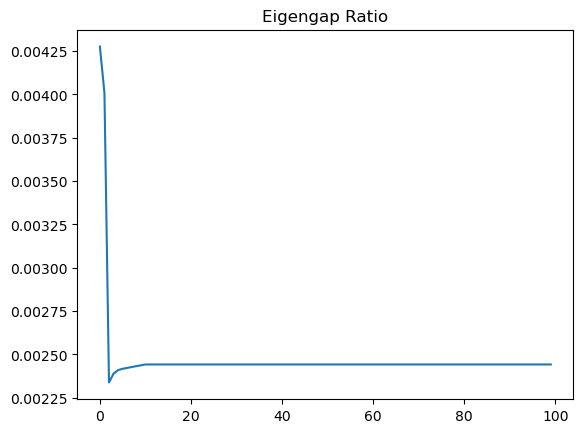

Final weights: [0. 0. 0. 0. 0. 0. 1. 0. 0.]
===== Individual acc_score | nmi=====
K_WL_1: 0.2650(acc); 0.0649(nmi) | weight: 0.0000
K_WL_3: 0.2550(acc); 0.0610(nmi) | weight: 0.0000
K_WL_5: 0.2550(acc); 0.0620(nmi) | weight: 0.0000
K_WL_7: 0.2333(acc); 0.0443(nmi) | weight: 0.0000
K_WL_9: 0.2367(acc); 0.0441(nmi) | weight: 0.0000
K_WL_11: 0.2483(acc); 0.0554(nmi) | weight: 0.0000
K_WL_13: 0.2500(acc); 0.0554(nmi) | weight: 1.0000
K_SP_dijkstra: 0.2250(acc); 0.0467(nmi) | weight: 0.0000
K_SP_floyd_warshall: 0.2250(acc); 0.0467(nmi) | weight: 0.0000
===== Joint kernel =====


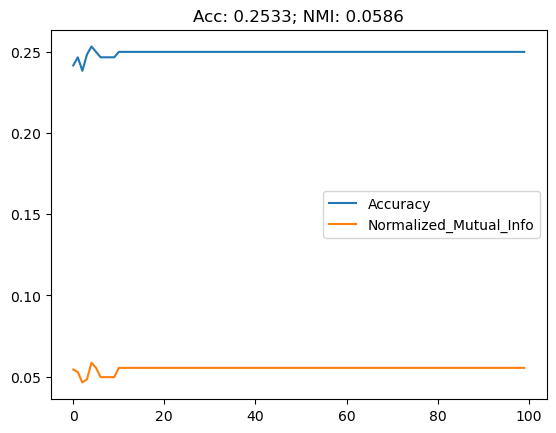

In [42]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'uniform', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.3598-----
eigengap ratio: [0.00332665]
acc_score: 0.25333333333333335; nmi: 0.05846993503900727

----- At No.11 iteration: sum: 1.0 norm: 0.3599-----
eigengap ratio: [0.00332651]
acc_score: 0.25666666666666665; nmi: 0.058748519133311417

----- At No.21 iteration: sum: 1.0 norm: 0.36-----
eigengap ratio: [0.00332634]
acc_score: 0.25666666666666665; nmi: 0.058748519133311417

----- At No.31 iteration: sum: 1.0 norm: 0.3601-----
eigengap ratio: [0.00332613]
acc_score: 0.25666666666666665; nmi: 0.058748519133311417

----- At No.41 iteration: sum: 1.0 norm: 0.3602-----
eigengap ratio: [0.00332589]
acc_score: 0.25666666666666665; nmi: 0.058748519133311417

----- At No.51 iteration: sum: 1.0 norm: 0.3604-----
eigengap ratio: [0.0033256]
acc_score: 0.25666666666666665; nmi: 0.058748519133311417

----- At No.61 iteration: sum: 1.0 norm: 0.3607-----
eigengap ratio: [0.00332525]
acc_score: 0.25666666666666665; nmi: 0.058748519133311417

----- At No.71 ite

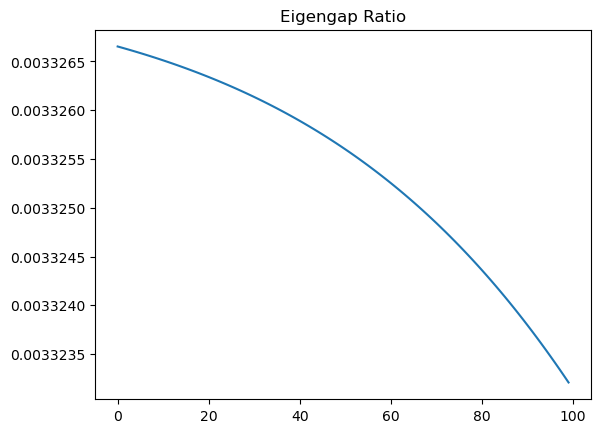

Final weights: [0.08882771 0.09177256 0.08673761 0.08403628 0.08257943 0.08180004
 0.08138125 0.20143256 0.20143256]
===== Individual acc_score | nmi=====
K_WL_1: 0.2650(acc); 0.0649(nmi) | weight: 0.0888
K_WL_3: 0.2550(acc); 0.0610(nmi) | weight: 0.0918
K_WL_5: 0.2550(acc); 0.0620(nmi) | weight: 0.0867
K_WL_7: 0.2333(acc); 0.0443(nmi) | weight: 0.0840
K_WL_9: 0.2367(acc); 0.0441(nmi) | weight: 0.0826
K_WL_11: 0.2483(acc); 0.0554(nmi) | weight: 0.0818
K_WL_13: 0.2500(acc); 0.0554(nmi) | weight: 0.0814
K_SP_dijkstra: 0.2250(acc); 0.0467(nmi) | weight: 0.2014
K_SP_floyd_warshall: 0.2250(acc); 0.0467(nmi) | weight: 0.2014
===== Joint kernel =====


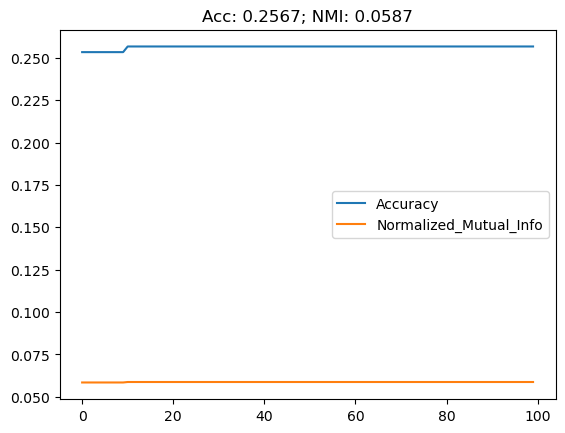

In [43]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

In [44]:
K_list = list(K_dict.values())
num_iter = 50
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen_inv', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

----- At No.1 iteration: sum: 1.0 norm: 0.3347-----
eigengap ratio: [0.00424278]
acc_score: 0.24; nmi: 0.0553473685413672

----- At No.11 iteration: sum: 1.0 norm: 0.4705-----
eigengap ratio: [0.00339995]
acc_score: 0.25166666666666665; nmi: 0.05464953657936713

----- At No.21 iteration: sum: 1.0 norm: 0.6231-----
eigengap ratio: [0.00238441]
acc_score: 0.24833333333333332; nmi: 0.048324936810055466



KeyboardInterrupt: 

## Random init

----- At No.1 iteration: sum: 1.0 norm: 0.2669-----
eigengap ratio: [0.02607541]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.11 iteration: sum: 1.0 norm: 0.2678-----
eigengap ratio: [0.02708382]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.21 iteration: sum: 1.0 norm: 0.2694-----
eigengap ratio: [0.02807886]
acc_score: 0.574468085106383; nmi: 0.18165729852067422

----- At No.31 iteration: sum: 1.0 norm: 0.2713-----
eigengap ratio: [0.02903667]
acc_score: 0.5851063829787234; nmi: 0.19485955418106837

----- At No.41 iteration: sum: 1.0 norm: 0.2739-----
eigengap ratio: [0.03000332]
acc_score: 0.5851063829787234; nmi: 0.19485955418106837

----- At No.51 iteration: sum: 1.0 norm: 0.2772-----
eigengap ratio: [0.03098172]
acc_score: 0.5797872340425532; nmi: 0.1881565335237106

----- At No.61 iteration: sum: 1.0 norm: 0.2805-----
eigengap ratio: [0.03188872]
acc_score: 0.5797872340425532; nmi: 0.1881565335237106

----- At No.71 iteration: sum: 1.

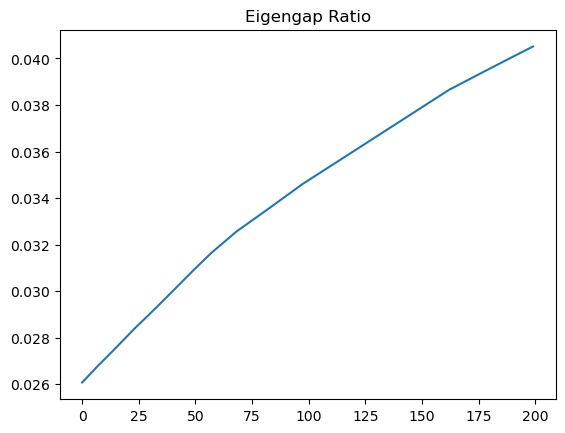

Final weights: [0.         0.02602282 0.17566081 0.08782538 0.12280588 0.15943276
 0.17294249 0.         0.         0.02783306 0.         0.00318878
 0.07351355 0.04107612 0.02021162 0.01998578 0.         0.04349139
 0.         0.         0.         0.02600957]
===== Individual acc_score | nmi=====
K_WL_1: 0.5531914893617021(acc); 0.12630262331970238(nmi) | weight: 0.0
K_WL_3: 0.5372340425531915(acc); 0.14117330695269498(nmi) | weight: 0.02602282314259281
K_WL_5: 0.5478723404255319(acc); 0.13613838486956323(nmi) | weight: 0.17566080683146956
K_WL_7: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.08782537513892283
K_WL_9: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.12280587878238404
K_WL_11: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.15943275825693648
K_WL_13: 0.5531914893617021(acc); 0.1414230072157862(nmi) | weight: 0.17294249118407423
K_GS_4: 0.7712765957446809(acc); 0.14275263914692107(nmi) | weight: 0.0
K_GS_5: 0.5851063829787234(acc

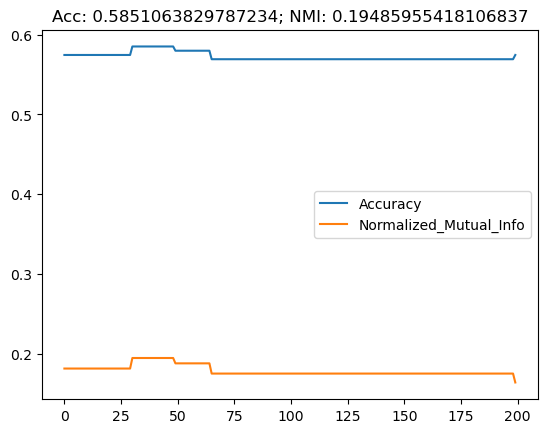

In [68]:
K_list = list(K_dict.values())
num_iter = 200
K_new, weights, score_dict = train(K_list, 'random', 2, 1e-4, 200)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, 200)

# Kernels with the same type

## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.4036-----
eigengap ratio: [0.05284909]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.11 iteration: sum: 1.0 norm: 0.4026-----
eigengap ratio: [0.05279563]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.21 iteration: sum: 1.0 norm: 0.4016-----
eigengap ratio: [0.05273713]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.31 iteration: sum: 1.0 norm: 0.4005-----
eigengap ratio: [0.05267327]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.41 iteration: sum: 1.0 norm: 0.3995-----
eigengap ratio: [0.05260373]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.51 iteration: sum: 1.0 norm: 0.3986-----
eigengap ratio: [0.05252824]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.61 iteration: sum: 1.0 norm: 0.3977-----
eigengap ratio: [0.05244657]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.71 iteration: sum: 1.0 

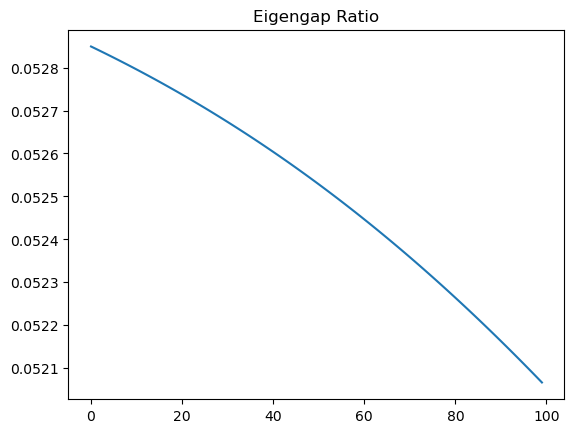

Final weights: [0.09851339 0.18778437 0.14897643 0.17247249 0.06925928 0.19778436
 0.12520969]
===== Individual acc_score | nmi=====
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0985
K_WL_3: 0.5372(acc); 0.1412(nmi) | weight: 0.1878
K_WL_5: 0.5479(acc); 0.1361(nmi) | weight: 0.1490
K_WL_7: 0.5532(acc); 0.1414(nmi) | weight: 0.1725
K_WL_9: 0.5532(acc); 0.1414(nmi) | weight: 0.0693
K_WL_11: 0.5532(acc); 0.1414(nmi) | weight: 0.1978
K_WL_13: 0.5532(acc); 0.1414(nmi) | weight: 0.1252
===== Joint kernel =====


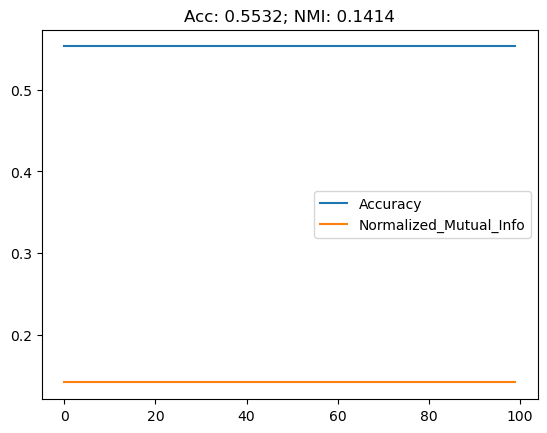

In [112]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

K_new, weights, score_dict = train(K_list, 'random', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.6526-----
eigengap ratio: [0.00486578]
acc_score: 0.5797872340425532; nmi: 0.004896519004286707

----- At No.11 iteration: sum: 1.0 norm: 0.8456-----
eigengap ratio: [0.07167511]
acc_score: 0.8670212765957447; nmi: 0.19408829044872525

----- At No.21 iteration: sum: 1.0 norm: 0.9329-----
eigengap ratio: [0.08287127]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09027952]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314



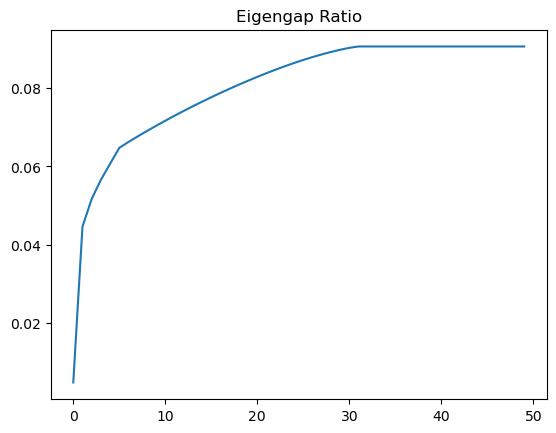

Final weights: [0. 0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_GS_4: 0.7712765957446809(acc); 0.14275263914692107(nmi) | weight: 0.0
K_GS_5: 0.5851063829787234(acc); 0.05575607792923468(nmi) | weight: 0.0
K_GS_6: 0.7553191489361702(acc); 0.08737371961034919(nmi) | weight: 0.0
K_GS_7: 0.6170212765957447(acc); 0.014077249308283699(nmi) | weight: 0.0
K_GS_8: 0.5957446808510638(acc); 0.01220624712783504(nmi) | weight: 0.0
K_GS_9: 0.8723404255319149(acc); 0.1830676965843314(nmi) | weight: 1.0
===== Joint kernel =====


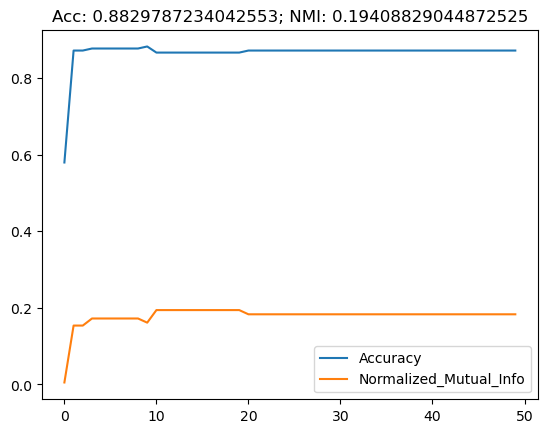

In [72]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_GS")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_GS")]
num_iter = 50

K_new, weights, score_dict = train(K_list, 'random', 2, 1e-2, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02108788]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.11 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02109411]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.21 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02110035]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.31 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02110658]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.41 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02111282]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.51 iteration: sum: 1.0 norm: 0.4082-----
eigengap ratio: [0.02111905]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.61 iteration: sum: 1.0 norm: 0.4083-----
eigengap ratio: [0.02112529]
acc_score: 0.5159574468085106; nmi: 0.32466786046867857

----- At No.71 iteration: su

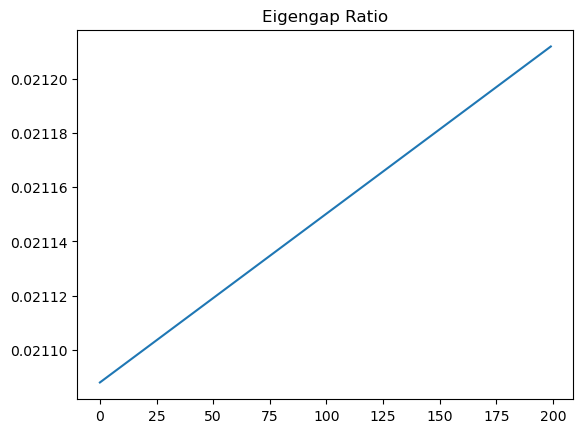

Final weights: [0.16391992 0.16503288 0.16616569 0.1672539  0.16830334 0.16932428]
===== Individual acc_score | nmi=====
K_RW_0.5: 0.5106382978723404(acc); 0.3455467666433281(nmi) | weight: 0.163919923891533
K_RW_1.0: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.1650328766331535
K_RW_1.5: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16616568529879938
K_RW_2.0: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16725389969455912
K_RW_2.5: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16830333658689606
K_RW_3.0: 0.5159574468085106(acc); 0.32466786046867857(nmi) | weight: 0.16932427789505897
===== Joint kernel =====


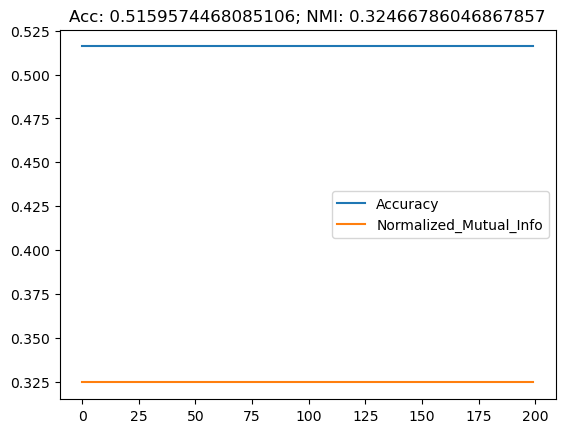

In [84]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_RW")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_RW")]
num_iter = 200

K_new, weights, score_dict = train(K_list, 'uniform', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.378-----
eigengap ratio: [0.05085671]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.11 iteration: sum: 1.0 norm: 0.3784-----
eigengap ratio: [0.05072341]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.21 iteration: sum: 1.0 norm: 0.3792-----
eigengap ratio: [0.05058326]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.31 iteration: sum: 1.0 norm: 0.3803-----
eigengap ratio: [0.05043707]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.41 iteration: sum: 1.0 norm: 0.382-----
eigengap ratio: [0.05028583]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.51 iteration: sum: 1.0 norm: 0.384-----
eigengap ratio: [0.05013062]
acc_score: 0.5531914893617021; nmi: 0.1414230072157862

----- At No.61 iteration: sum: 1.0 norm: 0.3865-----
eigengap ratio: [0.04997255]
acc_score: 0.5478723404255319; nmi: 0.13613838486956323

----- At No.71 iteration: sum: 1.0 no

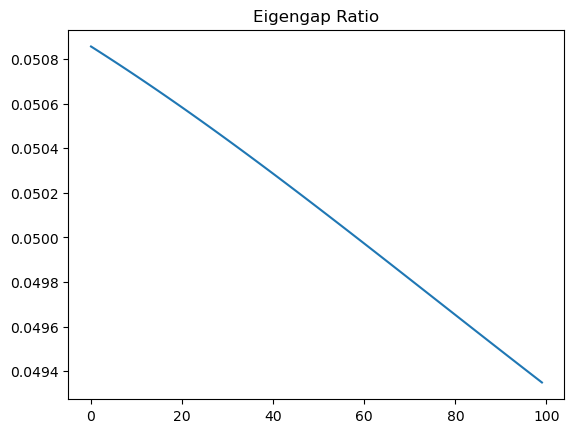

Final weights: [0.23136911 0.18864869 0.15656988 0.13171379 0.11214521 0.09629987
 0.08325346]
===== Individual acc_score | nmi=====
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.2314
K_WL_3: 0.5372(acc); 0.1412(nmi) | weight: 0.1886
K_WL_5: 0.5479(acc); 0.1361(nmi) | weight: 0.1566
K_WL_7: 0.5532(acc); 0.1414(nmi) | weight: 0.1317
K_WL_9: 0.5532(acc); 0.1414(nmi) | weight: 0.1121
K_WL_11: 0.5532(acc); 0.1414(nmi) | weight: 0.0963
K_WL_13: 0.5532(acc); 0.1414(nmi) | weight: 0.0833
===== Joint kernel =====


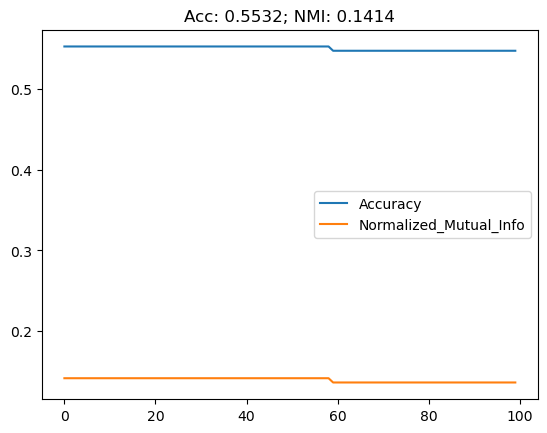

In [115]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_WL")]
num_iter = 100

K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-3, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.7546-----
eigengap ratio: [0.05090524]
acc_score: 0.8617021276595744; nmi: 0.17486808256216899

----- At No.11 iteration: sum: 1.0 norm: 0.9056-----
eigengap ratio: [0.0794925]
acc_score: 0.8670212765957447; nmi: 0.19408829044872525

----- At No.21 iteration: sum: 1.0 norm: 0.981-----
eigengap ratio: [0.08837725]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314



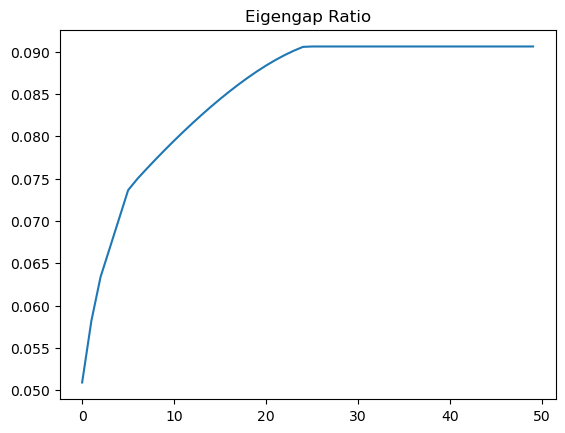

Final weights: [0. 0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.0000
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 1.0000
===== Joint kernel =====


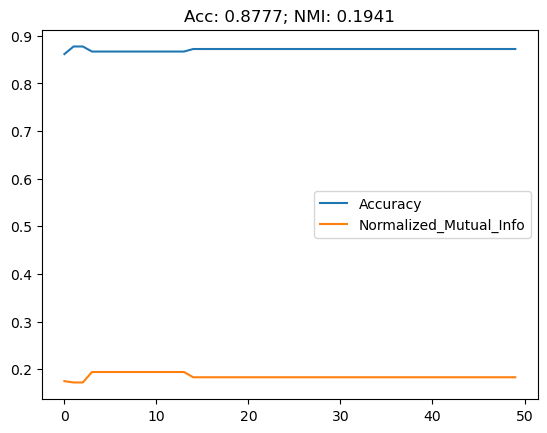

In [110]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_GS")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_GS")]
num_iter = 50

K_new, weights, score_dict = train(K_list, 'eigen', 2, 1e-2, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.7488-----
eigengap ratio: [0.00606283]
acc_score: 0.5531914893617021; nmi: 0.0031444437769900715

----- At No.11 iteration: sum: 1.0 norm: 0.8484-----
eigengap ratio: [0.0720642]
acc_score: 0.8670212765957447; nmi: 0.19408829044872525

----- At No.21 iteration: sum: 1.0 norm: 0.9353-----
eigengap ratio: [0.08316206]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.31 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09041832]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314

----- At No.41 iteration: sum: 1.0 norm: 1.0-----
eigengap ratio: [0.09062258]
acc_score: 0.8723404255319149; nmi: 0.1830676965843314



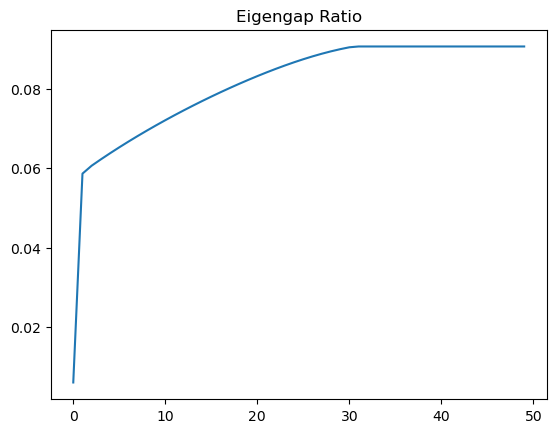

Final weights: [0. 0. 0. 0. 0. 1.]
===== Individual acc_score | nmi=====
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.0000
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 1.0000
===== Joint kernel =====


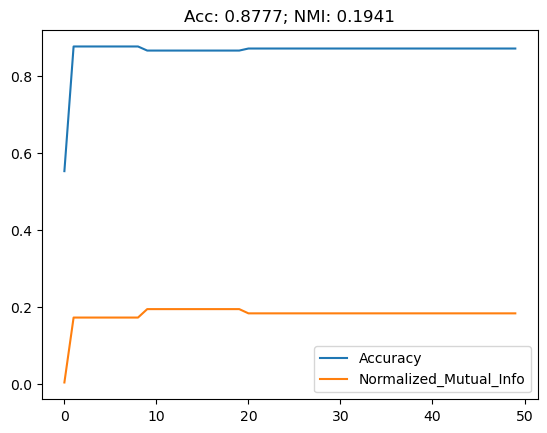

In [111]:
K_list = [K_dict[k] for k in K_dict.keys() if k.startswith("K_GS")]
kernel_name = [k for k in K_dict.keys() if k.startswith("K_GS")]
num_iter = 50

K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-2, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

# Subset kernels

----- At No.1 iteration: sum: 1.0 norm: 0.2586-----
eigengap ratio: [0.01628473]
acc_score: 0.7074468085106383; nmi: 0.24869782461798254

----- At No.11 iteration: sum: 1.0 norm: 0.2588-----
eigengap ratio: [0.01744644]
acc_score: 0.7021276595744681; nmi: 0.26081158016587475

----- At No.21 iteration: sum: 1.0 norm: 0.2615-----
eigengap ratio: [0.01861233]
acc_score: 0.7180851063829787; nmi: 0.2481104625646065

----- At No.31 iteration: sum: 1.0 norm: 0.2663-----
eigengap ratio: [0.01976866]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.41 iteration: sum: 1.0 norm: 0.2726-----
eigengap ratio: [0.02090928]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.51 iteration: sum: 1.0 norm: 0.28-----
eigengap ratio: [0.02203192]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.61 iteration: sum: 1.0 norm: 0.2884-----
eigengap ratio: [0.0231362]
acc_score: 0.7127659574468085; nmi: 0.2601069694306256

----- At No.71 iteration: sum: 1.0 n

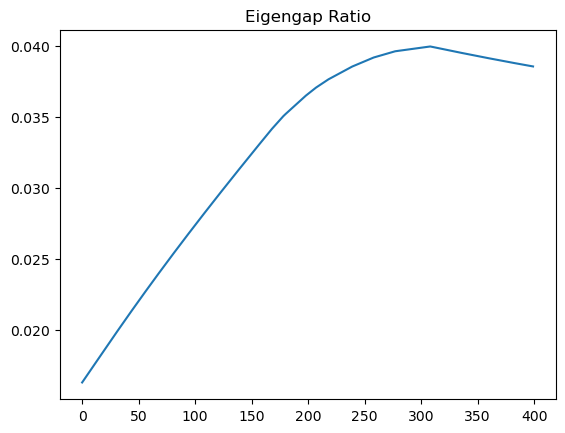

Final weights: [0.         0.         0.         0.         0.13519426 0.38256427
 0.16074716 0.16074716 0.16074716 0.         0.         0.
 0.         0.         0.        ]
===== Individual acc_score | nmi=====
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.1352
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 0.3826
K_SP_dijkstra: 0.6755(acc); 0.2106(nmi) | weight: 0.1607
K_SP_floyd_warshall: 0.6755(acc); 0.2106(nmi) | weight: 0.1607
K_SP_auto: 0.6755(acc); 0.2106(nmi) | weight: 0.1607
K_RW_0.5: 0.5106(acc); 0.3455(nmi) | weight: 0.0000
K_RW_1.0: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_1.5: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_2.0: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_2.5: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
K_RW_3.0: 0.5160(acc); 0.3247(nmi) | weight: 0.0000
=

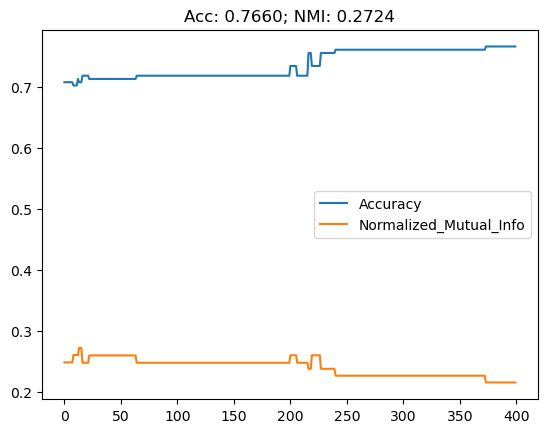

In [109]:
K_list = [K_dict[k] for k in K_dict.keys() if not k.startswith("K_WL")]
kernel_name = [k for k in K_dict.keys() if not k.startswith("K_WL")]
num_iter = 400
K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-4, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.2502-----
eigengap ratio: [0.02944339]
acc_score: 0.6223404255319149; nmi: 0.18831638399558634

----- At No.11 iteration: sum: 1.0 norm: 0.2516-----
eigengap ratio: [0.03100511]
acc_score: 0.6223404255319149; nmi: 0.18831638399558634

----- At No.21 iteration: sum: 1.0 norm: 0.2559-----
eigengap ratio: [0.03250244]
acc_score: 0.6170212765957447; nmi: 0.18120859853945742

----- At No.31 iteration: sum: 1.0 norm: 0.2622-----
eigengap ratio: [0.03394491]
acc_score: 0.6170212765957447; nmi: 0.18120859853945742

----- At No.41 iteration: sum: 1.0 norm: 0.27-----
eigengap ratio: [0.0353404]
acc_score: 0.5904255319148937; nmi: 0.18320323401970473

----- At No.51 iteration: sum: 1.0 norm: 0.2787-----
eigengap ratio: [0.03669545]
acc_score: 0.5904255319148937; nmi: 0.18320323401970473

----- At No.61 iteration: sum: 1.0 norm: 0.2882-----
eigengap ratio: [0.03801551]
acc_score: 0.5904255319148937; nmi: 0.18320323401970473

----- At No.71 iteration: sum: 

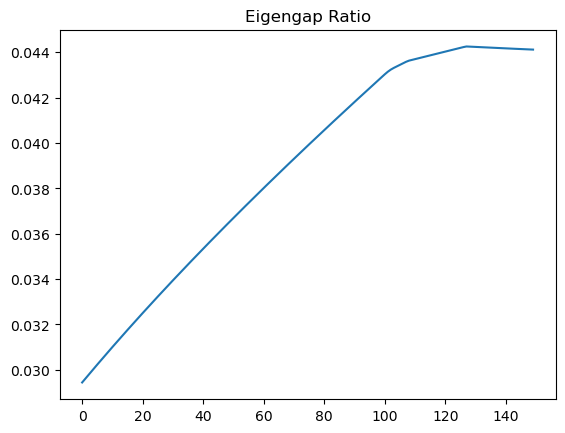

Final weights: [0.00284935 0.04826155 0.09350893 0.12874926 0.15610058 0.17807427
 0.19616744 0.         0.         0.         0.         0.02770002
 0.07808601 0.03016753 0.03016753 0.03016753]
===== Individual acc_score | nmi=====
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0028
K_WL_3: 0.5372(acc); 0.1412(nmi) | weight: 0.0483
K_WL_5: 0.5479(acc); 0.1361(nmi) | weight: 0.0935
K_WL_7: 0.5532(acc); 0.1414(nmi) | weight: 0.1287
K_WL_9: 0.5532(acc); 0.1414(nmi) | weight: 0.1561
K_WL_11: 0.5532(acc); 0.1414(nmi) | weight: 0.1781
K_WL_13: 0.5532(acc); 0.1414(nmi) | weight: 0.1962
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0000
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0000
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0000
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0000
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.0277
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 0.0781
K_SP_dijkstra: 0.6755(acc); 0.2106(nmi) | weight: 0.0302
K_SP_floyd_warshall: 0.6755(acc); 0.2106(nmi) | weight: 0.

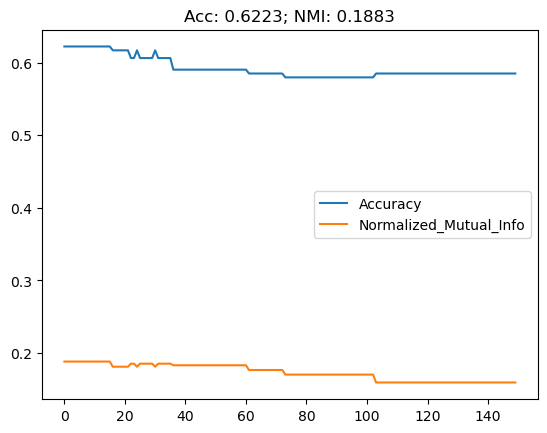

In [117]:
K_list = [K_dict[k] for k in K_dict.keys() if not k.startswith("K_RW")]
kernel_name = [k for k in K_dict.keys() if not k.startswith("K_RW")]
num_iter = 150
K_new, weights, score_dict = train(K_list, 'eigen_inv', 2, 1e-4, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)

----- At No.1 iteration: sum: 1.0 norm: 0.25-----
eigengap ratio: [0.03057857]
acc_score: 0.6329787234042553; nmi: 0.1667427545533293

----- At No.11 iteration: sum: 1.0 norm: 0.25-----
eigengap ratio: [0.03073049]
acc_score: 0.6329787234042553; nmi: 0.1667427545533293

----- At No.21 iteration: sum: 1.0 norm: 0.2501-----
eigengap ratio: [0.03088179]
acc_score: 0.6329787234042553; nmi: 0.1667427545533293

----- At No.31 iteration: sum: 1.0 norm: 0.2502-----
eigengap ratio: [0.03103246]
acc_score: 0.6329787234042553; nmi: 0.1667427545533293

----- At No.41 iteration: sum: 1.0 norm: 0.2503-----
eigengap ratio: [0.03118253]
acc_score: 0.6329787234042553; nmi: 0.1667427545533293

----- At No.51 iteration: sum: 1.0 norm: 0.2504-----
eigengap ratio: [0.031332]
acc_score: 0.6223404255319149; nmi: 0.18831638399558634

----- At No.61 iteration: sum: 1.0 norm: 0.2506-----
eigengap ratio: [0.03148088]
acc_score: 0.6223404255319149; nmi: 0.18831638399558634

----- At No.71 iteration: sum: 1.0 norm

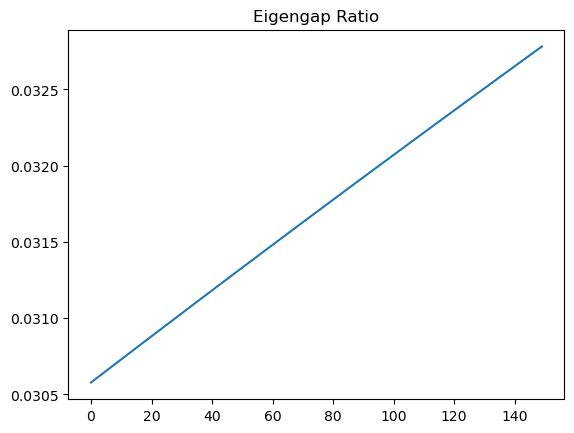

Final weights: [0.0548124  0.06142126 0.06775302 0.07268419 0.0765201  0.0796059
 0.0821474  0.05005084 0.05024886 0.05076018 0.05250837 0.05804515
 0.06594115 0.05916706 0.05916706 0.05916706]
===== Individual acc_score | nmi=====
K_WL_1: 0.5532(acc); 0.1263(nmi) | weight: 0.0548
K_WL_3: 0.5372(acc); 0.1412(nmi) | weight: 0.0614
K_WL_5: 0.5479(acc); 0.1361(nmi) | weight: 0.0678
K_WL_7: 0.5532(acc); 0.1414(nmi) | weight: 0.0727
K_WL_9: 0.5532(acc); 0.1414(nmi) | weight: 0.0765
K_WL_11: 0.5532(acc); 0.1414(nmi) | weight: 0.0796
K_WL_13: 0.5532(acc); 0.1414(nmi) | weight: 0.0821
K_GS_4: 0.7713(acc); 0.1428(nmi) | weight: 0.0501
K_GS_5: 0.5851(acc); 0.0558(nmi) | weight: 0.0502
K_GS_6: 0.7553(acc); 0.0874(nmi) | weight: 0.0508
K_GS_7: 0.6170(acc); 0.0141(nmi) | weight: 0.0525
K_GS_8: 0.5957(acc); 0.0122(nmi) | weight: 0.0580
K_GS_9: 0.8723(acc); 0.1831(nmi) | weight: 0.0659
K_SP_dijkstra: 0.6755(acc); 0.2106(nmi) | weight: 0.0592
K_SP_floyd_warshall: 0.6755(acc); 0.2106(nmi) | weight: 0.0

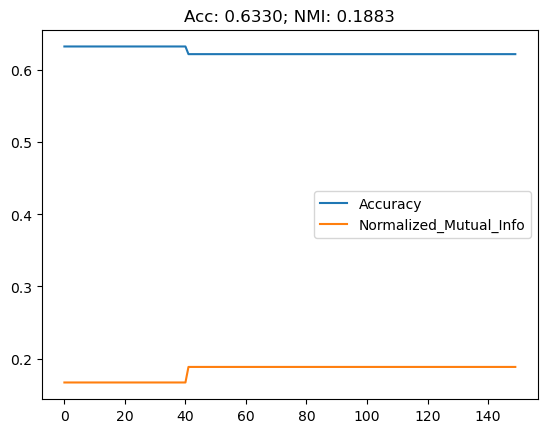

In [120]:
K_list = [K_dict[k] for k in K_dict.keys() if not k.startswith("K_RW")]
kernel_name = [k for k in K_dict.keys() if not k.startswith("K_RW")]
num_iter = 150
K_new, weights, score_dict = train(K_list, 'uniform', 2, 1e-5, num_iter)
print("Final weights:", weights)
display_results(kernel_name, K_list, weights, score_dict, num_iter)